https://earthquake.usgs.gov/earthquakes/search/

In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import pandas as pd

from parser.app import ClickHouseParser, CsvParser
from parser.db import client
from parser.repo import handler
from parser.repo.driver import create_tables, drop_tables

In [ ]:
year = 1990

start = datetime(year,3,6)
end = datetime(year,6,15)

parser = CsvParser(start, end, 'world', 'World_2000-2023')
parser.to_csv()

# Работа с таблицами

In [14]:
create_tables()

In [13]:
drop_tables()

In [ ]:
result = handler.show_tables()
print(result)

# Загрузка данных в БД

In [26]:
year = 2018
start = datetime(year,1, 1)
end = datetime(year, 6, 30)

parser = ClickHouseParser(start, end)

start (datetime.datetime(2018, 1, 1, 0, 0), datetime.datetime(2018, 6, 30, 0, 0)) period, with area world
2018-01-01 00:00:00 params=RequestParam(format='geojson', starttime='2023-06-18', endtime='2023-06-20', minlatitude='0.0', maxlatitude='89.0', minlongitude='0.0', maxlongitude='350.0', minmagnitude='2.5') timeout=20.0 endpoint='https://earthquake.usgs.gov/fdsnws/event/1/query' {'minlatitude': '0.0', 'maxlatitude': '89.0', 'minlongitude': '0.0', 'maxlongitude': '350.0'}
200


In [27]:
parser.upload_to_bd()

None


In [28]:
start = datetime(year, 7, 1)
end = datetime(year, 12, 31)
parser = ClickHouseParser(start, end)
parser.upload_to_bd()

start (datetime.datetime(2018, 7, 1, 0, 0), datetime.datetime(2018, 12, 31, 0, 0)) period, with area world
2018-07-01 00:00:00 params=RequestParam(format='geojson', starttime='2023-06-18', endtime='2023-06-20', minlatitude='0.0', maxlatitude='89.0', minlongitude='0.0', maxlongitude='350.0', minmagnitude='2.5') timeout=20.0 endpoint='https://earthquake.usgs.gov/fdsnws/event/1/query' {'minlatitude': '0.0', 'maxlatitude': '89.0', 'minlongitude': '0.0', 'maxlongitude': '350.0'}
200
None


In [ ]:
parser.update_bd()

In [ ]:
tmp_query = client.query_df("""
SELECT max(Date) as last
FROM quakes
""")

In [ ]:
last_datetime = tmp_query['last'].values[0].astype('M8[ms]').astype('O')
next_datetime = last_datetime + timedelta(0,1)
last_datetime, next_datetime

# Извлечение и анализ данных

In [29]:
tmp_df = client.query_df('SELECT * FROM quakes ORDER BY Date')

In [22]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541837 entries, 0 to 541836
Data columns (total 60 columns):
 #   Column                  Non-Null Count   Dtype        
---  ------                  --------------   -----        
 0   Magnitude               541837 non-null  float64      
 1   Date                    541837 non-null  datetime64[s]
 2   Longitude               541837 non-null  float64      
 3   Latitude                541837 non-null  float64      
 4   Mercury_earth_distance  541837 non-null  float64      
 5   Mercury_sun_distance    541837 non-null  float64      
 6   Mercury_hlat            541837 non-null  float64      
 7   Mercury_hlon            541837 non-null  float64      
 8   Mercury_size            541837 non-null  float64      
 9   Mercury_radius          541837 non-null  float64      
 10  Mercury_a_ra            541837 non-null  float64      
 11  Mercury_elong           541837 non-null  float64      
 12  Venus_earth_distance    541837 non-null  flo

In [8]:
tmp_df.columns.to_list()[2:]

['Longitude',
 'Latitude',
 'Mercury_earth_distance',
 'Mercury_sun_distance',
 'Mercury_hlat',
 'Mercury_hlon',
 'Mercury_size',
 'Mercury_radius',
 'Mercury_a_ra',
 'Mercury_elong',
 'Venus_earth_distance',
 'Venus_sun_distance',
 'Venus_hlat',
 'Venus_hlon',
 'Venus_size',
 'Venus_radius',
 'Venus_a_ra',
 'Venus_elong',
 'Mars_earth_distance',
 'Mars_sun_distance',
 'Mars_hlat',
 'Mars_hlon',
 'Mars_size',
 'Mars_radius',
 'Mars_a_ra',
 'Mars_elong',
 'Jupiter_earth_distance',
 'Jupiter_sun_distance',
 'Jupiter_hlat',
 'Jupiter_hlon',
 'Jupiter_size',
 'Jupiter_radius',
 'Jupiter_a_ra',
 'Jupiter_elong',
 'Saturn_earth_distance',
 'Saturn_sun_distance',
 'Saturn_hlat',
 'Saturn_hlon',
 'Saturn_size',
 'Saturn_radius',
 'Saturn_a_ra',
 'Saturn_elong',
 'Moon_earth_distance',
 'Moon_sun_distance',
 'Moon_hlat',
 'Moon_hlon',
 'Moon_size',
 'Moon_radius',
 'Moon_a_ra',
 'Moon_elong',
 'Sun_earth_distance',
 'Sun_sun_distance',
 'Sun_hlat',
 'Sun_hlon',
 'Sun_size',
 'Sun_radius',
 'Sun

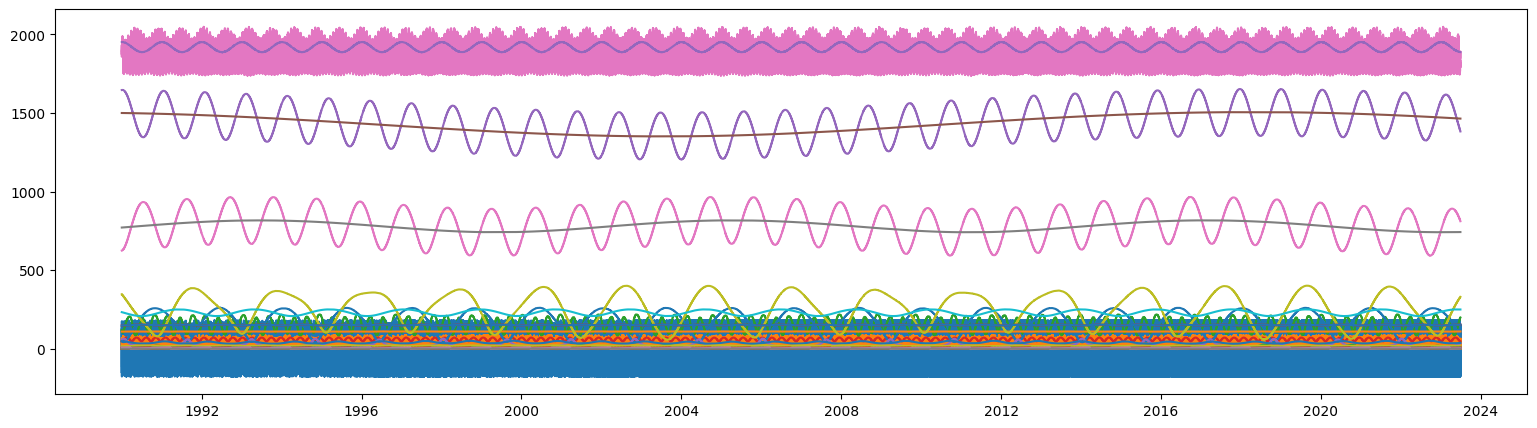

In [30]:
spectr = tmp_df.columns.to_list()[2:]
dates = tmp_df['Date'].values.tolist()

plt.figure(figsize=(19, 5))
for col in spectr:
    plt.plot(dates, tmp_df[col].values.tolist())
plt.show()

In [ ]:
tmp_query = client.query_df("""
SELECT toDate(Date), count(toDate(Date)), max(Magnitude), min(Magnitude), divide(avg(Mercury_earth_distance), 30)
FROM quakes
GROUP BY toDate(Date)
ORDER BY toDate(Date)
""")

In [ ]:
max_mag = tmp_query['max(Magnitude)'].values.tolist()
min_mag = tmp_query['min(Magnitude)'].values.tolist()
merc =  tmp_query['divide(avg(Mercury_earth_distance), 30)'].values.tolist()
dates = tmp_query['toDate(Date)'].values.tolist()

plt.plot(dates, max_mag)
plt.plot(dates, min_mag)
plt.plot(dates, merc)
plt.show()

# Нормализация спектра с помощью функций

In [31]:
from datafactory.normalize import msc, savgol, snv

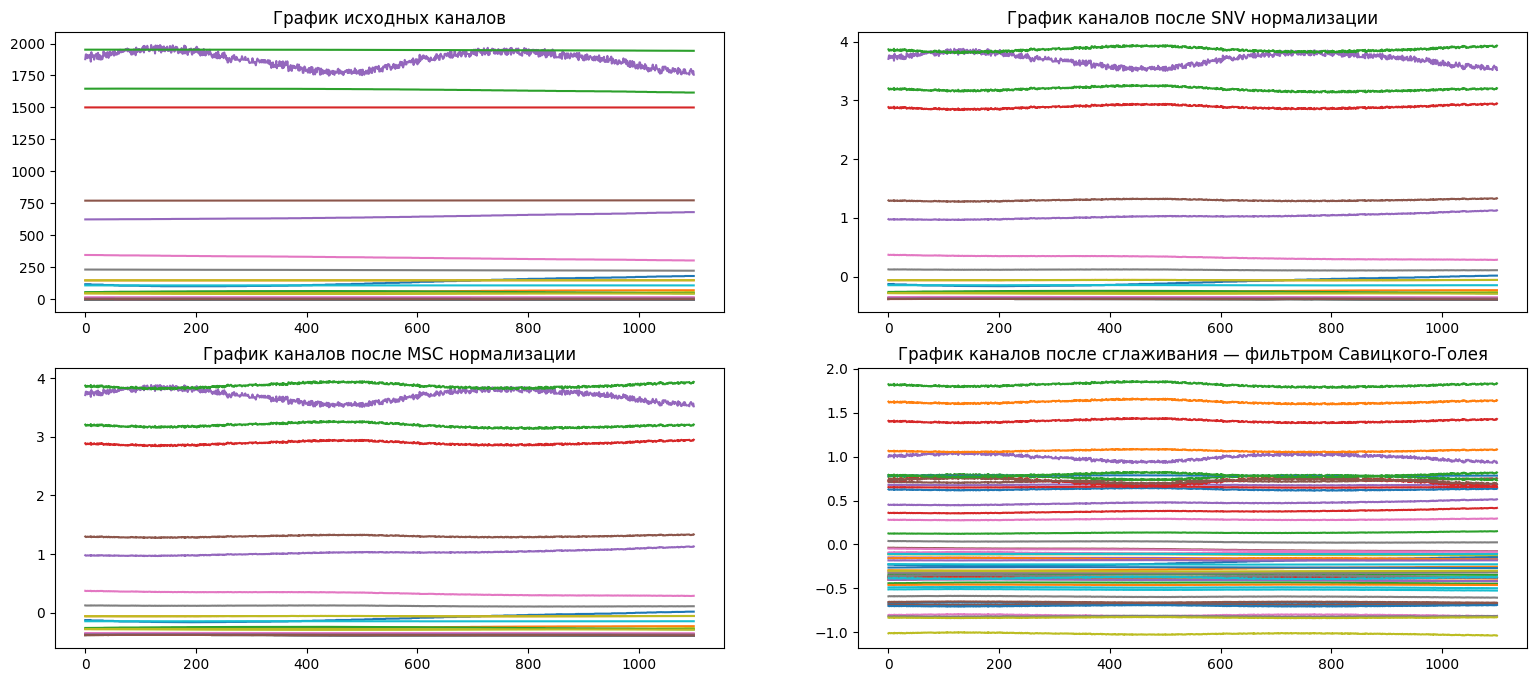

In [32]:
def graph_dataset(data_df: pd.DataFrame, snv_arr, msc_arr, savgol_arr):

    slice = 0, 1100
    chan = 0,150

    plt.figure(figsize=(19,8))

    plt.subplot(2,2,1)
    plt.plot(data_df.values[slice[0]:slice[1], chan[0]:chan[1]])
    plt.title('График исходных каналов')
    plt.subplot(2,2,2)
    plt.plot(snv_arr[slice[0]:slice[1],chan[0]:chan[1]])
    plt.title('График каналов после SNV нормализации')
    plt.subplot(2,2,3)
    plt.plot(msc_arr[slice[0]:slice[1], chan[0]:chan[1]])
    plt.title('График каналов после MSC нормализации')
    plt.subplot(2,2,4)
    plt.plot(savgol_arr[slice[0]:slice[1], chan[0]:chan[1]])
    plt.title('График каналов после сглаживания — фильтром Савицкого-Голея')

    plt.show()


snv_arr = snv(tmp_df.iloc[:, 4:].values)
msc_arr = msc(snv_arr)
savgol_arr = savgol(msc_arr)
graph_dataset(tmp_df.iloc[:, 4:], snv_arr, msc_arr, savgol_arr)